# Fashion MNIST classification with Vision Transformer

**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This code implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the fashion MNIST dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.





In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 3.9 MB/s 


## Setup

## Configure the hyperparameters

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class Config:
    # Origin image size
    input_size = 28
    # Input shape of image
    input_shape = [input_size, input_size, 1]
    # Learning rate of the Model. Replace the LR with 0.001
    learning_rate = 0.001
    # Weight decay rate of the Model
    weight_decay = 0.0001
    # Batch size of the Model
    batch_size = 256
    num_classes = 10
    num_epochs = 30
    image_size = 72
    patch_size = 6 #revert to 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ] #Size of the transformer layers
    transformer_layers = 8
    mlp_head_units = [2048, 1024] #size of the dense layers for the final classifier



In [ ]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

## Prepare the data

In [ ]:


(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


4431872/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) - y_train shape: (60000,)
x_test shape: (10000, 28, 28) - y_test shape: (10000,)


In [ ]:
train = np.array(x_train).reshape((-1, Config.input_size, Config.input_size, 1))
test = np.array(x_test).reshape((-1, Config.input_size, Config.input_size, 1))
#train_labels = train.pop("label")
#test_labels = test.pop("label")

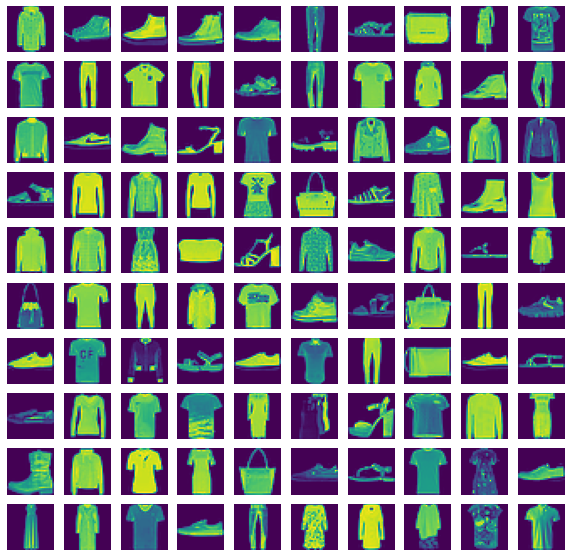

In [ ]:
indices = np.random.choice(train.shape[0], 100)
sample_images(train[indices].squeeze(), 10, 10)

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(Config.image_size,Config.image_size),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
             height_factor=0.2, width_factor=0.2
        ),
    ],
     name="data_augmentation",
 )

data_augmentation.layers[0].adapt(train)

## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

To split the image into fixed-size patches, use tf.image.extract_patches which collects patches from the input image.

**sizes**- To specify the dimensions of each patch. 

**strides**- Denotes the length of the gap between the start of one patch and the start of the next consecutive patch within the original image.

**rates**- It is a number to specify the patches to jump in the original image.

**padding**- Can be "VALID" for every patch to be fully contained in the image, or "SAME", to allow patches to be incomplete, and the remaining pixels will be filled with zeroes.

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


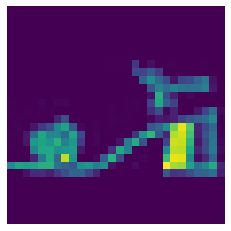

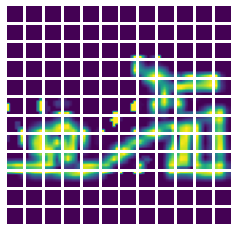

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
start_index = np.random.choice(train.shape[0] // 2)
image = train[start_index: start_index + Config.batch_size]
plt.imshow(np.squeeze(image[0]).astype("uint8"))
plt.axis("off")


resized_image = tf.image.resize(
    tf.convert_to_tensor(image), size=(Config.image_size,Config.image_size)
)

patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=Config.input_shape)
    # Augment data.
   # augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(Config.patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(Config.transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads, key_dim=Config.projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(Config.num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
keras.backend.clear_session()
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 patches (Patches)              (None, None, 36)     0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      11584       ['patches[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 144, 64)     128         ['patch_encoder[0][0]']          
 alization)                                                                                   

## Compile, train, and evaluate the mode

In [ ]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=Config.learning_rate, weight_decay=Config.weight_decay
    )

vit_classifier.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ]        
    )

In [ ]:

import time
# Measuring the time taken by the model to train
StartTime=time.time()

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True)
]

history = vit_classifier.fit(
        x=train,
        y=y_train,
        epochs=Config.num_epochs,
        batch_size=Config.batch_size,      
        validation_split=0.1,
        callbacks=callbacks)

EndTime=time.time()
print("###### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ######')

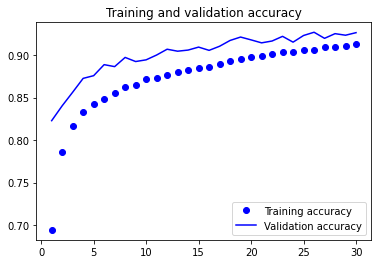

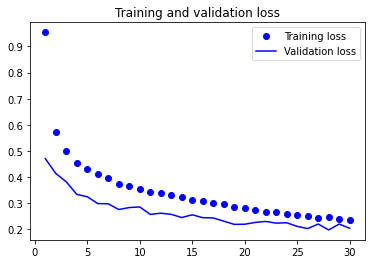

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
vit_classifier.load_weights("model_old.keras")
_, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 19s 60ms/step - loss: 0.2171 - accuracy: 0.9209 - top-5-accuracy: 0.9994
Test accuracy: 92.09%
Test top 5 accuracy: 99.94%


Original label is Trouser and predicted label is Trouser


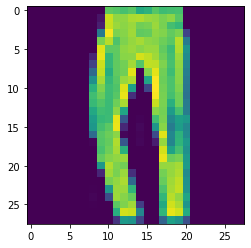

In [ ]:
labels = '''T-shirt/top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Ankle_boot'''.split()
 
# select the image from our test dataset
image_number = 5
 
# display the image
plt.imshow(x_test[image_number])
 
# load the image in an array
n = np.array(x_test[image_number])
 
# reshape it
p = n.reshape(1, 28, 28, 1)
 
# pass in the network for prediction and
# save the predicted label
predicted_label = labels[vit_classifier.predict(p).argmax()]
 
# load the original label
original_label = labels[y_test[image_number]]
 
# display the result
print("Original label is {} and predicted label is {}".format(
    original_label, predicted_label))